In [1]:
from audioeqinfer import finder parameterfunction
import numpy as np

# GET BACK (EQ)
This project is a study around the connections between topics learned in STA410 and ideas behind music production. In particular, I use three ideas to solve three musical problems.

- I extend on class modules to build a module that allows you to "listen" to how probability density functions "sound". 

- I build a module that allows you to equalize a track using arbitrary functions.

- I then build a module that reconstructs an EQ function using normal flows and sampling methods discussed in this course.

This notebook explores the elements and experiments I ran as I added to the package. 

IMPORTANT!!:
- Please run the cells of this notebook as you go through, rather than all at once, since I overwrite the file "output.wav" a few times to demonstrate different things. 
- It also would be worth listening with headphones or monitors, so that you can hear some of the nuance in the sound.
- START WITH VOLUME LOW!!!

In [2]:
# Generate markov chain audio signal
#GENERATE WHITE NOISE, for example
f = lambda x: np.random.normal(0, 1, x)
f = lambda x: np.random.uniform(-1, 1, x)

Recall our Monte Carlo rejection sampling function from week 2:

In [4]:
# Generate a sound signal (mono)
samplerate = 44100
duration = 1
with AudioFile("normal.wav", "w", samplerate=samplerate, num_channels=1) as af:
    af.write(np.random.normal(0, 1, (1,samplerate*duration)))
with AudioFile("uniform.wav", "w", samplerate=samplerate, num_channels=1) as af:
    af.write(np.random.uniform(0, 1, (1,samplerate*duration)))
with AudioFile("exponential.wav", "w", samplerate=samplerate, num_channels=1) as af:
    af.write(np.random.exponential(1, (1,samplerate*duration)))
with AudioFile("gamma.wav", "w", samplerate=samplerate, num_channels=1 ) as af:
    af.write(np.random.gamma(1, 1, (1,samplerate*duration)))
with AudioFile("logistic.wav", "w", samplerate=samplerate, num_channels=1) as af:
    af.write(np.random.logistic(0, 1, (1,samplerate*duration)))

This is pretty cool, but they kind of all sound the same, with slight differences in volume, but minimal differences in texture.

In [5]:
show_audio_with_controls("normal.wav")
show_audio_with_controls("uniform.wav")
show_audio_with_controls("exponential.wav")
show_audio_with_controls("gamma.wav")
show_audio_with_controls("logistic.wav")


normal.wav


uniform.wav


exponential.wav


gamma.wav


logistic.wav


Now we are going to implement EQ!
What is EQ? https://en.wikipedia.org/wiki/Equalization_(audio)
A 10 minute video of a dude explaining how musicians use EQ: https://www.youtube.com/watch?v=vRa_Zk90lDc

Remember when we discussed the fast fourier transform principles? Well we can use this to build an eq!

People only sometimes use FFT to do this in reality.  https://www.meldaproduction.com/tutorials/text/equalizers#fft 
Partially because https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem
Which creates a problem of "poor bass resolution", where lower frequencies suffer resolusion issues.


https://en.wikipedia.org/wiki/Spectral_density

(11026,)


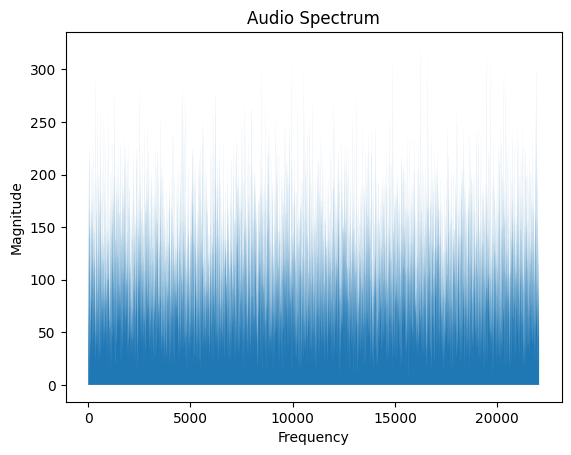

In [ ]:
duration = 0.5
with AudioFile("normal.wav") as af:
    file = af.read(samplerate*duration)[0]

# FFT computation
def fft_diagram(array, samplerate,**kwargs):
    '''
    This function computes the FFT of the audio signal and plots the spectrum
    file: audio signal (Make this short, computation is expensiver for longer signals)
    '''

    fft_result = np.fft.rfft(array)
    magnitude = np.abs(fft_result)#[:len(fft_result)//2]
    freq = np.fft.rfftfreq(array.size, d=1./samplerate)
    print(fft_result.shape)
    ## Visualize the spectrum
    fig, ax = plt.subplots()
    ax.set(**kwargs)
    ax.plot(freq, magnitude, linewidth = 0.01)
    ax.fill_between(freq, magnitude, alpha=1)
    ax.set_title("Audio Spectrum")
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Magnitude")
    plt.show()
    #return magnitude, freq
fft_diagram(file, samplerate)

WOW! This is really cool. We just mathematically replicated a tool for analyzing the frequencies in a short clip of audio. Mixing consoles often use a linear fft analyzer to quickly identify problem frequencies that show up during live concerts! 

Mixing producers, however, rely less on visualization, because of low bass resolution, which is a mathematical consequence of the fast fourier transform being an approximation that doesn't account for all possible frequencies. This effect is similar to STAT410 material with approximation in floating point numbers, where numerical approximations get worse as numbers get further from infinity, the fourier transform approximations get worse as our real world frequencies approach zero. It's really cool that audio people have instinctively internalized this mathematical context using their ears.

You can see the effects of bass resolution by experimenting with the frequencies below:

(11026,)


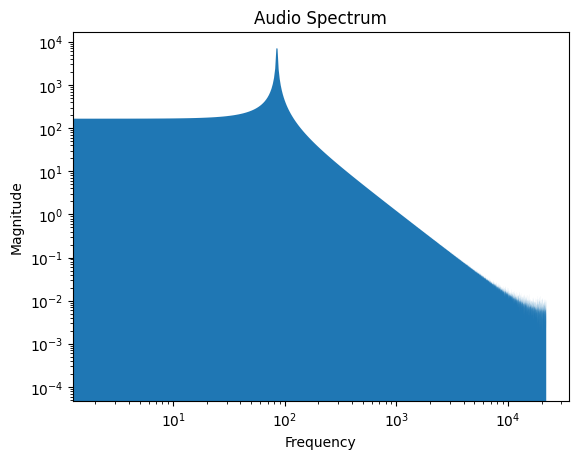

In [7]:
duration = 0.5
#TODO little buttons
frequency = 85 #compare 80,85,440,445 which is magnitudes greater than it's spike
with AudioFile("BassSine.wav", samplerate=samplerate, num_channels=1) as af:
    af.write(np.sin(2*np.pi*frequency*np.arange(samplerate*duration)/samplerate))

with AudioFile("BassSine.wav") as af:
    audio = af.read(af.samplerate*duration)[0]
    a = fft_diagram(audio, af.samplerate, xscale = "log",yscale ="log")

Alright, now that we've discussed taking issues with approximation in FFT, and shown how to generate diagrams, we are going to create a parametric EQ.

Parametric EQ is basically a way to shrink and boost (un)desireable frequencies in the spectrum. Beginners often play with this too much, professionals generally care more about cutting than about boosting. 

Here is an image of the Paid (200$) version of the Melda audio production parametric EQ.
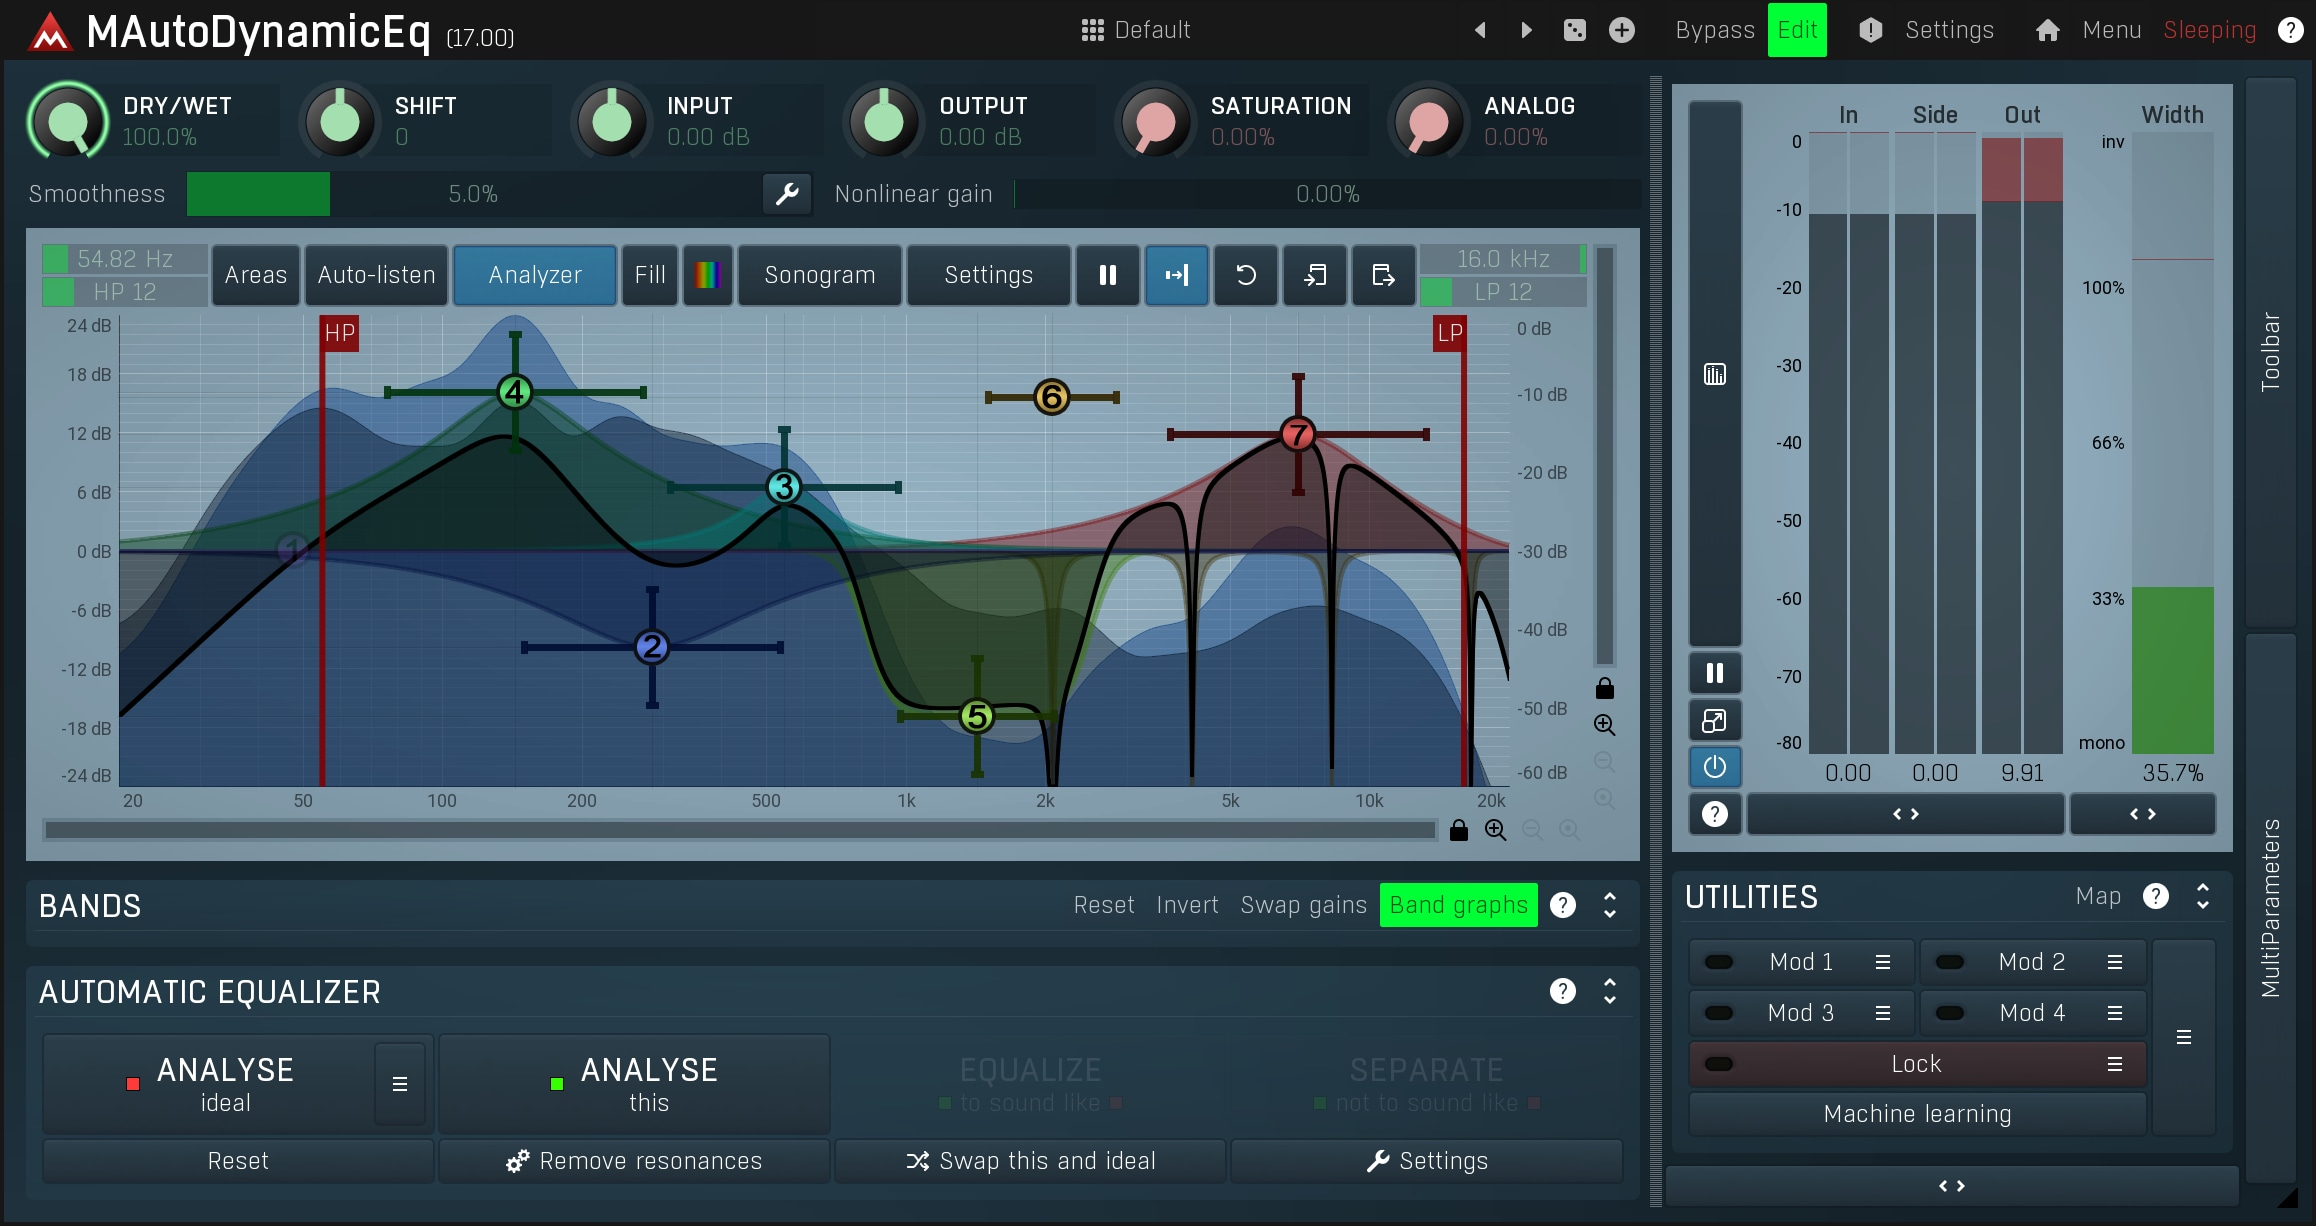



One thing I generally use this for as an intermediate producer is to cut resonant frequencies in my cheap microphone. The physical engineering of my mic leads the casing itself to resonate, so I find and cut the volume of these frequencies. A cool way to think about this is that the microphone itself has an EQ function, and a producer is trying to find and apply the inverse function by ear. 

The remainder of this project is going to be done in mono, which is easier because we don't have to worry about phase, which is inaudible in mono, but matters in binaural audio.

In [8]:
duration = 0.3

#the g function is our multiplier, where x is the frequency. 
#this equation just lowers the volume of all frequencies by half.
#x is a frequency, from like 0 to 22050
g = lambda x: 0.1

def EQ_FILE(input_file, output_file, g):
  with AudioFile(input_file) as f:
    # Open an audio file to write to:
    with AudioFile(output_file, 'w', f.samplerate, 1) as o:
      # Read one second of audio at a time, until the file is empty:
      while f.tell() < f.frames:
          chunk = f.read(f.samplerate)[0]
          fft_result = np.fft.rfft(chunk)
          freq = np.fft.rfftfreq(chunk.size, d=1./samplerate)
          together = np.array(list(zip(freq,fft_result)))

          processed = together[:,1]*g(together[:,0]) #vectorized, very fast (hopefully)
          #processed = fft_result#*1
          newsignal = np.fft.irfft(processed)
          
          o.write(newsignal)
          #wow. this is so cool. wowowowow.

f1, f2 = "normal.wav", "output.wav"
EQ_FILE(f1, f2, g)
show_audio_with_controls(f1)
show_audio_with_controls(f2)

normal.wav


output.wav


Nice, now we are going to create a very expressive function in the b-spline basis space so as to paramaterize our EQ function.

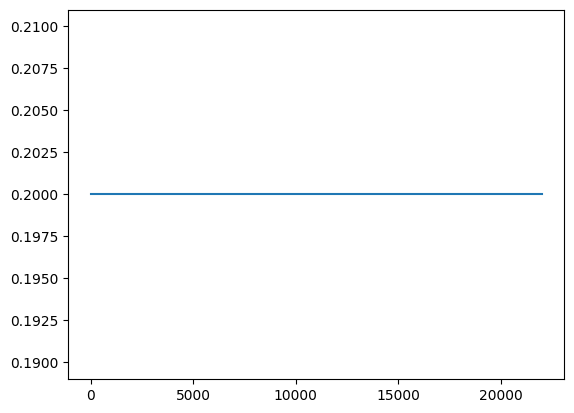

/home/widea/Vscode/.venv/lib/python3.13/site-packages/scipy/interpolate/_fitpack_impl.py:323: ComplexWarning: Casting complex values to real discards the imaginary part
  y, ier = dfitpack.splev(t, c, k, x, ext)


normal.wav


output.wav


In [ ]:
class ParameterFunction:
    def __init__(self, n_parameters = 502, domain = (0., 22050.)):
        self.n_parameters = n_parameters
        self.domain = domain

        # Set up knots based on number of desired parameters
        n_internal_knots = max(n_parameters - 4, 1)  # Cubic splines need degree + 1
        self.knots = np.linspace(domain[0], domain[1], n_internal_knots + 2)[1:-1]  # exclude endpoints

        self.design_info = dmatrix(f"bs(x, knots={list(self.knots)}, degree=3, include_intercept=True) - 1", 
                         {"x": np.linspace(0., 22050., 500)}).design_info
    
    def set_coefficients(self, coefficients):
        self.coefficients = coefficients

    def number_of_coefficients_needed(self):
        return len(self.knots) + 4
    
        # Build the design matrix for this specific x value
    def __call__(self, x:np.array) -> np.array:
        basis_at_x = build_design_matrices([self.design_info], {"x": x})[0]
        y_value = np.dot(basis_at_x, self.coefficients)
        return y_value

    def evaluate(self,x:np.array) -> np.array:
        basis_at_x = build_design_matrices([self.design_info], {"x": x})[0]
        y_value = np.dot(basis_at_x, self.coefficients)
        return y_value
    
    def graph(self, show_basis = False):
        x = np.linspace(0., 22000., 100)
        y = self.evaluate(x)

        if show_basis:
            basis = build_design_matrices([self.design_info], {"x": x})[0]
            for i in range(basis.shape[1]):
                plt.plot(x, basis[:,i])
        
        plt.plot(x,y)
        plt.show()
    
    def fit_to_data(self, frequency, magnitude):
        basis_matrix = build_design_matrices([self.design_info], {"x": frequency})[0]

        # Fit the GLM model
        fit = sm.GLM(magnitude, basis_matrix).fit()
        self.coefficients = fit.params

        


b = np.array([0.2]*20)
eq = ParameterFunction()

eq.set_coefficients(np.array([0.2]*(eq.number_of_coefficients_needed())))
eq.graph()
EQ_FILE(f1, f2, eq)
show_audio_with_controls(f1)
show_audio_with_controls(f2)

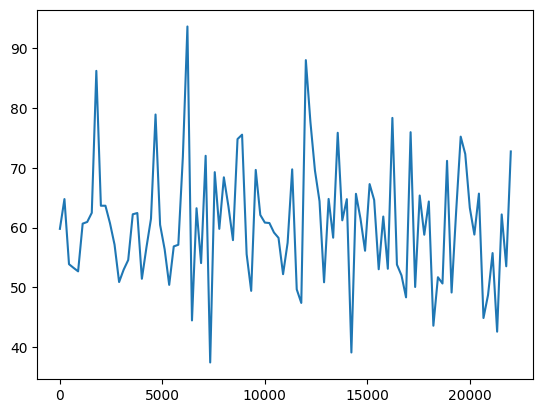

In [10]:
duration = 0.2
with AudioFile("normal.wav") as af:
    file = af.read(samplerate*duration)[0]

fft_result = np.fft.rfft(file)
magnitude = np.abs(fft_result)
frequencies = np.fft.rfftfreq(file.size, d=1./samplerate)

eq = ParameterFunction()
eq.fit_to_data(frequencies,magnitude)
eq.graph()

WOWZERS
WE ARE SO CLOSE TO COMPLETING THE EQ :) Lets try a couple of them. In particular, lets try transforming our white noise into a type of noise called 1/f or pink noise https://en.wikipedia.org/wiki/Pink_noise. This sound has deep connections mathematically to biological systems, frequency of moon crater impact sizes and gravitational waves. It also sounds nice. Hence it is occasionally used as reference audio when mixing tracks https://www.soundonsound.com/techniques/mixing-pink-noise-reference.

Below we transform our white noise file into a mono 1/f noise audio using our EQ function built out of bsplines.

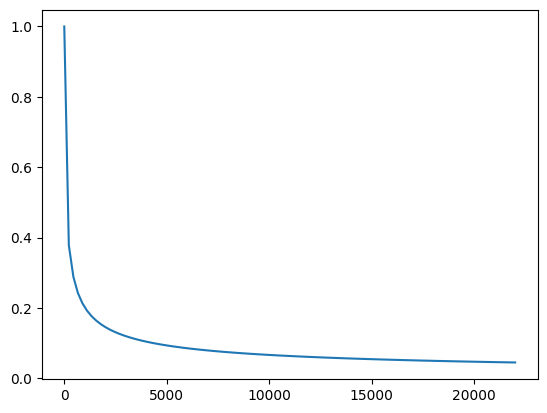

normal.wav


output.wav


In [11]:

eq = ParameterFunction()
b = np.array([1/x**0.5 for x in range(1,eq.number_of_coefficients_needed()+1)])
eq.set_coefficients(b)
eq.graph()
EQ_FILE(f1, f2, eq)
show_audio_with_controls(f1)
show_audio_with_controls(f2)


# GETTING BACK EQ
Whew, we have applied alot of class ideas into an audio context. 
TO recap:
- We used FFT to analyze audio charachteristics
- We demonstrated the effects of approximation error in the Fast Fourier Transform.
- We built an EQ class that can EQ to an arbitrary function
- We built a class that allows you to weight bspline basis functions to generate a function along the EQ parameters, that can also be used by our EQ class.

Done yet? nope.

I want to use sampling techniques from the first few weeks of class in order to reconstruct a likely eq for a given audio file. This has real world uses, like calculating how realworld audio equipment distorts real signal.


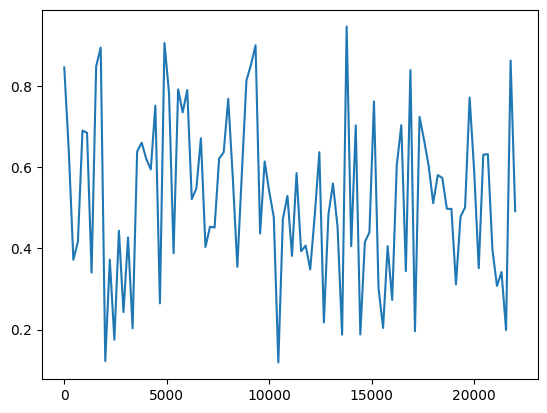

normal.wav


output.wav


In [12]:
np.random.seed(411) #mess around with this seed and realize how good your ears are at immediately knowing the difference
eq = ParameterFunction()
b = np.random.uniform(0,1,eq.number_of_coefficients_needed()) #202 parameters might be alot.... maybe should change.
eq.set_coefficients(b)

eq.graph()
EQ_FILE(f1, f2, eq)
show_audio_with_controls(f1)
show_audio_with_controls(f2)

Imagine x vectors as a bunch of verical cuts with time on the horizontal axis

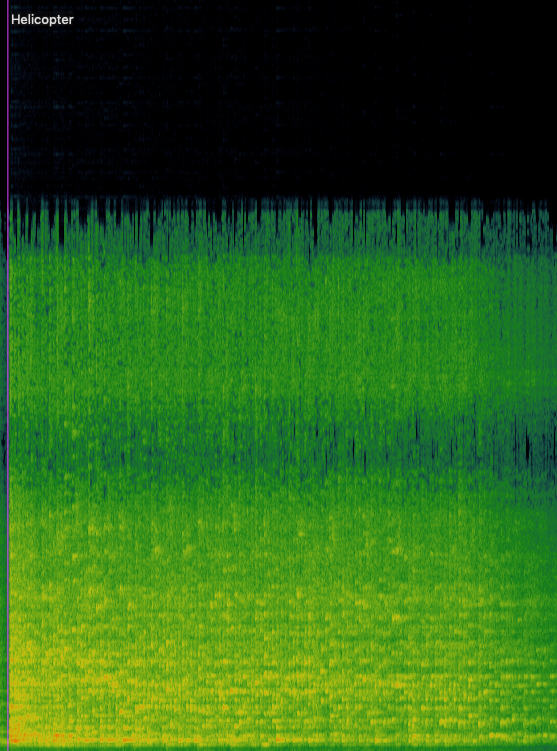

By altering the signal along the frequency spectrum we create a multiplier for each horizontal axis. Doubling or halving the values along this axis. 

In [13]:
## USING UNDERLYING SIGNAL
# Process, sample from a random timestamp
input_file = "normal.wav"
output_file = "output.wav"


## SOME MATH
$\Theta$ : is the space of possible eq parameters. $\theta$ being a given parameter vector.

$X'$: is the space of possible observations for the frequency time output signal after EQ edits. $x'$ is a matrix of actual observations (we ignore order). $x'_t$ being the vector of the magnitude of the frequencies from fft at time t.

$X$: is the space of possible input signals (real signals). $x$ is the actual underlying signal.

We want to know $E(\theta|x')$.

## What we know

$x' = g_\theta(x )$ where $X \bot \Theta$ and $g$ is 1:1

We can figure out that

$$f_{X'}(x') = \int_\Theta  f_X(g^{-1}(x')) f_\Theta (\theta)$$

$$f_{X'|\Theta}(x'|\theta) = \int_X\begin{cases} 1 & g_\theta(x) = x' \\  0 & g_\theta(x) \neq x' \end{cases} f_{X}(x) = f_X(g^{-1}_\theta(x'))$$


And thus: 
$$f_{\Theta|X'}(\theta|x') = \frac{f_{X'|\Theta}(x'|\theta) f_\Theta (\theta)}{f_{x'}(x')} = \frac{f_X(g^{-1}_\theta(x')) f_\Theta (\theta)}{\int_\Theta f_X(g^{-1}(x')) f_\Theta (\theta)}$$

Which is a restatement of conditional probability but restated in terms of the underlying signal. (whereas we cant really know much about our observed signal independent of our $\theta$)

to do this, we are going to need a good estimate of the multivariate pdf $f_X(x)$. Which we will estimate using normalized flows. since our dimensionality is very high.

The important thing here is that eventually we want to estimate $E(\theta|x')$

## Finding f_X

In [14]:

class f_X():
    def __init__(self):
        features = 442 #because we have 44100 samples per second, and 20 milliseconds of audio, rrft size is (n/2+1)
        self.base_dist = distributions.StandardNormal(shape=[features])
        self.transforms = []
        for _ in range(3):
            self.transforms.append(MaskedAffineAutoregressiveTransform(features=features, hidden_features=features))
        self.transform = CompositeTransform(self.transforms)
        self.flow = Flow(self.transform, self.base_dist)
        self.optimizer = optim.Adam(self.flow.parameters(),lr=1e-4)
    
    # def __call__(self,a):
    #     return self.flow.log_prob(a) #returns our pdf evaluations

    def log_pdf(self, x):
        return self.flow.log_prob(x)

    def sample(self):
        return self.flow.sample(1)
    
    def sample_n(self, n):
        return self.flow.sample(n)
    
    def audio_process(self, underlying_signal_file): #this function processes audio chunks
        #We need this function because audio files can be really big.
        #So we need to process online. we'll then divide into 20ms segment, run fft. then call our train function.
        #each chunk will be a training epoch.

        with AudioFile(underlying_signal_file) as f:
            # Open an audio file to write to:
            while f.tell() < f.frames: #while we haven't read the entire file
                chunk = f.read(f.samplerate*5)[0] #read 5 seconds of audio, first channel
                X = []
                #divide the chunk into 20ms chunks
                for i in range(0, len(chunk), f.samplerate//50):
                    subChunk = chunk[i:i+f.samplerate//50]
                    fft_result = np.fft.rfft(subChunk)
                    magnitude = np.abs(fft_result)
                    #frequencies = np.fft.rfftfreq(chunk.size, d=1./samplerate)
                    X.append(magnitude)
                X = np.stack(X)
                self.train(X)
    
    def train(self, x, n_iterations=1, verbose=False): #This is a very simple training loop
        if len(x.shape) == 1:
        # If input is flat, reshape to (1, features)
            x = x.reshape(1, -1)

        x_tensor = torch.tensor(x).float()
        
        for i in range(n_iterations):
            self.optimizer.zero_grad()
            loss = -self.flow.log_prob(inputs=x_tensor).mean()
            loss.backward()
            self.optimizer.step()
            if verbose:
                print(f"Iteration {i}, Loss: {loss.item()}")

In [15]:
#generate_long_white_noise
samplerate = 44100
duration = 3600 #1 hour of white noise
# with AudioFile("1hrnormal.wav", "w", samplerate=samplerate, num_channels=1) as af:
#     af.write(np.random.normal(0, 1, (1,samplerate*duration)))

In [16]:
#train our f_X distribution this might take a minute, depending on how many iterations you assign.
f = f_X()
f.audio_process("1hrnormal.wav")

In [17]:
g_inverse = lambda x: 1/g(x)
#this is our g inverse function. we need this to calculate the pdf of our transformed distribution.
#this is super invertable, because we EQ'd our file by multiplying by this, so we undo by dividing.

In [18]:
with AudioFile("1hrnormal.wav") as i:
    chunk = i.read(i.samplerate*0.02)[0]
    fft_result = np.fft.rfft(chunk)
    magnitude = np.abs(fft_result)
    print(f.log_pdf(np.array([magnitude])))

tensor([-4044.0171], grad_fn=<AddBackward0>)


In [19]:
np.array([magnitude]).shape

(1, 442)

## What have we represented?

Our f_X function is a representation of the probability distribution of 20ms slices of sound from our audio source. This is extremely useful as it is an understanding of conditional frequencies and dependence on eachother.

In [20]:
fX_samples = f.sample_n(100)

In [21]:
print(fX_samples.shape)

torch.Size([100, 442])


What does our representation sound like?

In [22]:
with AudioFile("fX_sound.wav", "w", samplerate=samplerate, num_channels=1) as o:
    for sample in fX_samples:
        sample = sample.detach().numpy()
        signal = np.fft.irfft(sample)
        o.write(signal)
show_audio_with_controls("fX_sound.wav")
show_audio_with_controls("normal.wav")

fX_sound.wav


normal.wav


Sounds pretty similar, especially if you turn down the normal signal so that the two have similar volume. Though if you listen closely you can hear the normalizing flows generates a little bit of strange action at the high end of the spectrum.

## So what if we are given an altered signal?

If we are given a signal, the quotient between a representation of fX and a representation of the sample is a decent way to guess at what the g(x) function is. (since our distorted samples is just a multiplication of the real listened to ("sampled") frequencies of f(x)).

I've thought about a couple of ways of doing it...

Clearly based on our analysis:
$$E[\theta|x'] = \int_{\Theta} \theta f_{\Theta|X'}(\theta|x') 

= \int_{\Theta} \theta \frac{f_X(g^{-1}_\theta(x')) f_\Theta (\theta)}{\int_\Theta { f_X(g_{\tilde \theta_i}^{-1}(x')) f_\Theta (\theta)}}$$


g_\theta^{-1} (x')
Which suggests that we could sample from our observed signal and our parameter space, to develop more precise beliefs about the parameters of our EQ.

We will further make some assumptions about $\theta$. Namely that all possible postive values between 0 and 1 are equally likely for each $\theta_i$ parameter. This assumption is definitely true for our example, since this is how we coded the randomization of the parameters of our EQ. Other prior assumptions may be better if you know more about the nature of the frequency distortions being applied.


This assumption makes $f_\Theta (\theta)$ a constant and thus an appropriate approximation method for our expectation:
Where: $\tilde \theta_i$ is a sampled vector with the same shape as $\theta$
$$E[\theta|x'] \approx \frac{\sum_i \tilde \theta_i f_X(g_{\tilde \theta_i}^{-1}(x'))}{\sum_i f_X(g_{\tilde \theta_i}^{-1}(x'))}$$

We face two computational challenges in doing this:
1) x' can be arbitrarily big (because audiofiles are large) So we have to handle it in chunks. Meaning we should do some sort of online algorithm
2) fX faces numeric underflow when exponentiating, so we have to do our math in logspace.

To face these constraints:
1) use online algorithm
2) do algorithm in logspace


Taking the log of the inside of the summation and then exponentiating, we get:
$$\log E[\theta|x'] \approx \log [ LSE(\log (\theta_i) + \log f_X(g^{-1}_\theta(x'))) - LSE( \log g_\theta^{-1}(x') + \log f_X(g_{\theta}^{-1}(x'))) ]$$

There's a really cool tool to do this called Log Sum Exp:
- https://en.wikipedia.org/wiki/LogSumExp
- It is explained really well on this Stack Overflow https://stackoverflow.com/questions/65233445/how-to-calculate-sums-in-log-space-without-underflow


I'm going to try to figure out the best way to do this online...




In [78]:
class EQ_finder:
    def __init__(self, f_X, n_coefficients):
        self.f_X = f_X
        self.n_coefficients = n_coefficients


    # def find_eq(self,sample,n_thetas_per_batch, n_audio_chunks, chunk_duration = 0.02):
    #     '''
    #         This function is kind of the point of the whole project.
    #         It uses an online algorithm, because audio files can be really big.
    #         It processes the audio file in chunks. 
    #         For each chunk, sample a lot of potential theta values.
    #         Then calculate the FX pdf for the inverse eq at those lambda values of the audio chunk.
    #         Then we continue, storing n, and the average E(theta|X) values.
    #     '''
    #     #PROCESS CHUNK
    #     pfunk = ParameterFunction()
    #     average_theta = np.zeros(self.n_coefficients)
    #     n = 0

    #     with AudioFile(sample) as f:
    #         #Find number of chunks
    #         n_audio_chunks = int(f.frames/(f.samplerate*chunk_duration)) #20ms chunks

    #         #for each chunk, sample theta values
    #         for n in range(n_audio_chunks):

    #             #pick   a random chunk
    #             chunk_start = np.random.randint(0, f.frames - f.samplerate*chunk_duration)
    #             f.seek(chunk_start)

    #             #read a chunk of audio
    #             chunk = f.read(f.samplerate*0.02)[0]
    #             results = self.fft_chunk(chunk,f.samplerate) #fft chunk
    #             thetamat = self.sample_theta(n_thetas_per_batch)#SAMPLE THETA

    #             running_sum_log_numerator = np.zeros(self.n_coefficients)
    #             log_numerators = []

    #             running_sum_log_denominator = -np.inf
    #             log_denominators = []

    #             #for each theta, calculate the pdf of the inverse eq at the audio chunk
    #             for theta in thetamat:
    #                 pfunk.set_coefficients(theta)
    #                 g_inv= lambda x: (1/np.asarray(pfunk(x[:,0])))*x[:,1]

    #                 transformed = g_inv(results)
    #                 transformed = np.array([transformed])

    #                 #calculate the pdf of the inverse eq at the audio chunk
    #                 log_pdf = self.f_X.log_pdf(transformed.astype(np.float32)).item()
    #                 log_numerators.append(log_pdf + np.log(theta)) #this is correct when theta values are > 0 which they are. 

    #                 log_denominators.append(log_pdf)
                    

    #             #calculate the logsumexp of the weights
    #             log_numerators = np.array(log_numerators)
    #             log_denominators = np.array(log_denominators)

                

    #             log_batch_sum = logsumexp(log_numerators, axis = 0)
    #             log_batch_sum_denominator = logsumexp(log_denominators)

    #             #update running numerator
    #             running_sum_log_numerator = logsumexp(np.vstack([log_batch_sum, running_sum_log_numerator]), axis = 0) 

    #             #update running denominator
    #             # print(log_batch_sum_denominator.shape)
    #             # print(running_sum_log_denominator.shape)
    #             running_sum_log_denominator = logsumexp([log_batch_sum_denominator,running_sum_log_denominator])
    #             print(f"Processed chunk {n + 1}/{n_audio_chunks}", end="\r")
                
    #     logE = running_sum_log_numerator - running_sum_log_denominator
    #     average_theta = np.exp(logE)
    #     return average_theta
    
    #Painstakingly vectorized below

    def find_eq(self, sample, n_thetas_per_batch, n_audio_chunks, chunk_duration=0.02):
        '''
        Estimate EQ parameters via importance sampling across random audio chunks
        Using this method is not reccommended.
        '''
        pfunk = ParameterFunction()
        running_sum_log_numerator = np.full(self.n_coefficients, -np.inf)  # log(0) = -inf
        running_sum_log_denominator = -np.inf
        sr = None

        with AudioFile(sample) as f:
            total_frames = f.frames
            sr = f.samplerate
            total_chunks = int(total_frames / (sr * chunk_duration))  # 20ms chunks

            for n in range(n_audio_chunks):
                # Pick a random chunk
                chunk_start = np.random.randint(0, total_frames - int(sr * chunk_duration))
                f.seek(chunk_start)

                # Read a chunk of audio
                chunk = f.read(int(sr * chunk_duration))[0]
                results = self.fft_chunk(chunk, sr)  # FFT transform

                # Sample theta matrix
                thetamat = self.sample_theta(n_thetas_per_batch)  # (n_samples, n_coefficients)

                # Build basis matrix once
                basis_at_freqs = build_design_matrices([pfunk.design_info], {"x": results[:, 0]})[0]
                basis_at_freqs = np.asarray(basis_at_freqs)  # (n_freqs, n_basis_terms)

                # Predict all θs at once
                predicted_responses = basis_at_freqs @ thetamat.T  # (n_freqs, n_samples)
                predicted_responses = predicted_responses.T  # (n_samples, n_freqs)

                # g_inv for all θs
                g_inv_transformed = (1 / predicted_responses) * results[:, 1]  # (n_samples, n_freqs)
                g_inv_transformed = g_inv_transformed.astype(np.float32)

                # Compute log-pdfs for all transformed samples
                log_pdfs = self.f_X.log_pdf(g_inv_transformed).detach().cpu().numpy()  # (n_samples,)

                # Now, batch compute log(θ * p(X|θ))
                log_weighted_thetas = log_pdfs[:, None] + np.log(thetamat)  # (n_samples, n_coefficients)

                # Calculate logsumexp across θ samples for numerator and denominator
                log_batch_sum = logsumexp(log_weighted_thetas, axis=0)  # (n_coefficients,)
                log_batch_sum_denominator = logsumexp(log_pdfs)  # scalar

                # Update running sums
                running_sum_log_numerator = logsumexp(np.vstack([running_sum_log_numerator, log_batch_sum]), axis=0)
                running_sum_log_denominator = logsumexp([running_sum_log_denominator, log_batch_sum_denominator])

                print(f"Processed chunk {n + 1}/{n_audio_chunks}", end="\r")

        # After all chunks
        logE = running_sum_log_numerator - running_sum_log_denominator
        average_theta = np.exp(logE)

        return average_theta

    def find_eq_MH(self, sample, n_audio_chunks, burn_in = 10, keep_each = 1, std_dev = 0.01, chunk_duration=0.02):
        '''
        Estimate EQ parameters using a Metropolis-Hastings algorithm across random audio chunks
        '''
        pfunk = ParameterFunction()
        sum_theta = np.zeros(self.n_coefficients)
        sr = None

        with AudioFile(sample) as f:
            total_frames = f.frames
            sr = f.samplerate
            
            #create initial theta
            theta_current = self.sample_theta(1)[0]
            #compute current logprob:
            pfunk.set_coefficients(theta_current)
            g_inv = lambda x: (1 / np.asarray(pfunk(x[:, 0]))) * x[:, 1]
            
            #find chunk
            chunk_start = np.random.randint(0, total_frames - int(sr * chunk_duration))
            f.seek(chunk_start)

            # Read a chunk of audio
            chunk = f.read(int(sr * chunk_duration))[0]
            results = self.fft_chunk(chunk, sr)

            transformed = g_inv(results)
            transformed = np.array([transformed])

            #calculate the pdf of the inverse eq at the audio chunk
            log_pdf_current = self.f_X.log_pdf(transformed.astype(np.float32)).item()

            for n in range(n_audio_chunks+burn_in):
                # Pick a random chunk
                chunk_start = np.random.randint(0, total_frames - int(sr * chunk_duration))
                f.seek(chunk_start)

                # Read a chunk of audio
                chunk = f.read(int(sr * chunk_duration))[0]
                results = self.fft_chunk(chunk, sr)

                # Create proposal theta
                theta_proposal = theta_current + np.random.normal(0, std_dev, self.n_coefficients)
                # Ensure proposal is valid (non-negative)
                theta_proposal = np.maximum(theta_proposal, 0)

                # Compute log pdf for proposal
                pfunk.set_coefficients(theta_proposal)
                g_inv = lambda x: (1 / np.asarray(pfunk(x[:, 0]))) * x[:, 1]

                # Transform x' into x
                transformed = g_inv(results)
                transformed = np.array([transformed])

                # Calculate the pdf of the inverse eq at the audio chunk
                log_pdf_proposal = self.f_X.log_pdf(transformed.astype(np.float32)).item()

                # Compute acceptance probability
                log_alpha = log_pdf_proposal - log_pdf_current
                alpha = np.exp(log_alpha)

                # Accept or reject the proposal
                if np.random.uniform(0, 1) < alpha:
                    theta_current = theta_proposal
                    log_pdf_current = log_pdf_proposal

                if n > burn_in and n % keep_each == 0:
                    sum_theta += theta_current
                
                print(f"Processed {n + 1}/{n_audio_chunks}", end="\r")
            return sum_theta / ((n_audio_chunks) / keep_each)


    def fft_chunk(self, chunk, samplerate):
        fft_result = np.fft.rfft(chunk)
        freq = np.fft.rfftfreq(chunk.size, d=1./samplerate)
        magnitude = np.abs(fft_result)
        together = np.array(list(zip(freq,magnitude)))
        return together
    
    def sample_theta(self,n):
        return np.random.uniform(0,1,(n,self.n_coefficients))

In [45]:
EQ_FILE("1hrnormal.wav", "output.wav", g)

In [82]:
#found_coeffs = findr.find_eq("output.wav", 1000, 500)
findr = EQ_finder(f, eq.number_of_coefficients_needed())
found_coeffs_mh = findr.find_eq_MH("output.wav", 10000, burn_in = 10, keep_each = 1, std_dev = 0.01)

/tmp/ipykernel_102270/2926797101.py:202: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(log_alpha)


I'll save you the experience of running the importance sampling version of this function. It faces really high dimensionality, takes a long time, and is pretty bad. The biggest reason for that is that each individual 20ms audio sample is relatively low information about the total function. On the other hand, MH is fast, works really well, and yields great results. See below:

0.04506083921390681
0.0004003880286449614


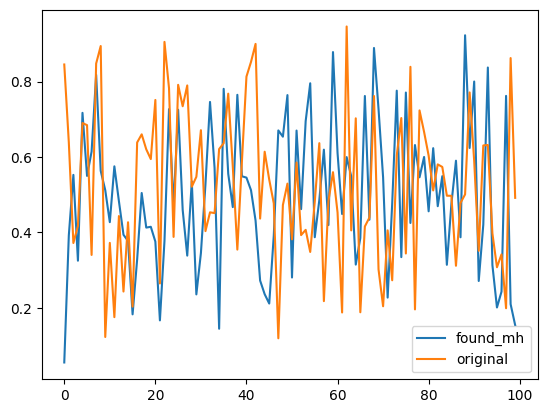

In [84]:
#print(np.abs(np.sum(eq.coefficients-found_coeffs))/len(eq.coefficients))
print(np.abs(np.sum(eq.coefficients-found_coeffs_mh))/len(eq.coefficients))
#foundeq = ParameterFunction()
foundmh = ParameterFunction()
#foundeq.set_coefficients(found_coeffs)
foundmh.set_coefficients(found_coeffs_mh)
plt.plot(foundmh.evaluate(np.linspace(0., 22000., 100)), label = "found_mh")
#plt.plot(foundeq.evaluate(np.linspace(0., 22000., 100)), label = "found_MH")
plt.plot(eq.evaluate(np.linspace(0., 22000., 100)), label = "original")

plt.legend()
plt.show()

In [97]:
eq.number_of_coefficients_needed()

502